# Triplets
updated analysis to the point of the EARS talk, using triplets instad of permutations.
Some of the figures are saved to the DAC4 folder, and the code should be moved or refactored.

In [20]:
from pathlib import Path
import itertools as itt

import joblib as jl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from bioinfokit.analys import stat
import pandas as pd
import seaborn as sns
from IPython.display import display
from statannot import add_stat_annotation
from cycler import cycler

from src.data.region_map import region_map
from src.metrics.consolidated_dprimes import _load_site_formated_raste, single_cell_dprimes, full_dPCA_dprimes
from src.data.dPCA import _cpp_dPCA, get_centered_means
from src.visualization.fancy_plots import _raster, unit_line, savefig
from src.metrics.significance import _significance
from src.metrics.dprime import flip_dprimes
from src.metrics.reliability import signal_reliability
from src.data.rasters import raster_from_sig
from src.data.load import load

In [21]:
#general plottin formating
plt.style.use('dark_background')

light_color_cycle = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

trans_color_map = {'silence': '#377eb8',  # blue
                   'continuous': '#ff7f00',  # orange
                   'similar': '#4daf4a',  # green
                   'sharp': '#a65628'}  # brown

params = {'axes.labelsize': 15,
          'axes.titlesize': 20,
          'axes.spines.top': False,
          'axes.spines.right': False,
          'axes.prop_cycle': light_color_cycle,
          'xtick.labelsize': 11,
          'ytick.labelsize': 11,
          'lines.markersize': 8,
          'figure.titlesize': 30,
          'figure.figsize': [4,4],
          'figure.autolayout':True,
          'svg.fonttype': 'none',
          'font.sans-serif': 'Arial',
          'legend.loc': 'upper right',
          'legend.frameon': False,
          'legend.fontsize': 15,
          'legend.markerscale': 3,
          }

widescreen = [13.3, 7.5]

plt.rcParams.update(params)

In [22]:
# pulls DF, removes unused columns and data, refactor redunant id columns and create probe_id
DF = jl.load(Path(f'../data/210302_consolidated_summary_DF_alpha_0.05/dprime_absolute-None_montecarlo-1000_raster_fs-30_reliability-0.1_smoothing_window-0_zscore-True'))

# no need for means or mean policy, working on permutations only
ff_probe = DF.probe != 'mean'
ff_pairs = DF.context_pair != 'mean'
ff_stim = DF.stim_type == 'triplets'
ff_mean = DF.mean_signif_type == 'shuffles'

ff_analylis = DF.analysis.isin(['SC', 'pdPCA'])
ff_corr = DF.mult_comp_corr == 'consecutive_3'
ff_metric = DF.metric.isin(['significant_abs_mass_center', 'significant_abs_mean', 'significant_abs_sum'])

good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
            'probe', 'metric', 'value']
filtered = DF.loc[ff_stim & ff_mean & ff_pairs & ff_probe & ff_analylis & ff_corr & ff_metric, good_cols]

# rename metrics and analysis for ease of ploting
filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                 'significant_abs_mean': "mean d'",
                                                 'significant_abs_sum': "integral (d'*ms)"})
filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                     'pdPCA': 'population'})

filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
filtered = filtered.drop(columns=['cellid', 'siteid'])

filtered['value'] = filtered['value'].fillna(value=0)

display(filtered)

,analysis,mult_comp_corr,region,context_pair,probe,metric,value,id
128790,single cell,consecutive_3,PEG,silence_continuous,2,center of mass (ms),0.000000,AMT028b-01-2
128791,single cell,consecutive_3,PEG,silence_continuous,2,center of mass (ms),0.000000,AMT028b-06-1
128792,single cell,consecutive_3,PEG,silence_continuous,2,center of mass (ms),0.000000,AMT028b-07-1
128793,single cell,consecutive_3,PEG,silence_continuous,2,center of mass (ms),0.000000,AMT028b-07-2
128794,single cell,consecutive_3,PEG,silence_continuous,2,center of mass (ms),0.000000,AMT028b-10-2
...,...,...,...,...,...,...,...,...
4604262,population,consecutive_3,PEG,silence_similar,6,mean d',1.560340,ARM019a
4604263,population,consecutive_3,PEG,silence_sharp,6,mean d',1.154915,ARM019a
4604264,population,consecutive_3,PEG,continuous_similar,6,mean d',0.000000,ARM019a
4604265,population,consecutive_3,PEG,continuous_sharp,6,mean d',0.000000,ARM019a


In [23]:
filtered['trans_pair'] = filtered['context_pair']
trans_order = list(filtered.context_pair.unique())

ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()


In [24]:
# counts the total ne umber of values for each comparison (SC, fDPCA) x (sile_diff, sile_same, diff_diff, same_diff)
# counts the proportion of signifciant vs non singificant(zero-zero) values

# set the array to group by id, context_pair, and probe. Keeping analysis, region and transision_pair
# the final array should have analysis, region and trans pair as rowns, and total count, and significants as columns

def nozero_mean(arr):
    arr[arr==0] = np.nan
    return np.nanmean(arr)

def nozero_count(arr):
    return np.sum(arr>0)

group_ready = pivoted.set_index(['analysis', 'region', 'trans_pair']).loc[:, filtered.metric.unique()]
agg_funcs = {'center of mass (ms)': [('mean duration', nozero_mean)],
             "mean d'": [('mean amplitude', nozero_mean),
                                     ('total', 'size'),
                                     ('n_signif', nozero_count)]}

grouped = group_ready.groupby(['analysis', 'region', 'trans_pair']).agg(agg_funcs)
grouped.columns = grouped.columns.droplevel(0)
grouped['significant %'] = grouped.n_signif / grouped.total * 100

## count number of cells or sites with significant contextual effects

In [25]:
for anal in ['single cell', 'population']:
    all_id_df= pivoted.loc[pivoted.analysis == anal, ['id']]
    all_id_count = len(all_id_df.id.unique())

    good_id_df= pivoted.loc[(pivoted.analysis == anal) & (pivoted["integral (d'*ms)"] > 0), ['id']]
    good_id_count = len(good_id_df.id.unique())

    print(f'{anal}\n{good_id_count} of {all_id_count}. {good_id_count/all_id_count*100:.2f}%')

single cell
464 of 845. 54.91%
population
35 of 35. 100.00%


## how many contextual instances per site/cell and on average

In [26]:
goodcount = pivoted.set_index(['analysis', 'id']).loc[:,["integral (d'*ms)"]]
agg_funcs = {"integral (d'*ms)": [('all',np.size),
                                  ('good', nozero_count)]}
goodcount = goodcount.groupby(['analysis','id']).agg(agg_funcs)
goodcount.columns = goodcount.columns.droplevel(0)
goodcount = goodcount.loc[goodcount['good'] > 0]
goodcount['percent'] = goodcount['good'] / goodcount['all'] * 100
# display(goodcount)

for anal in ['single cell', 'population']:
    arr = goodcount.loc[(anal), 'percent'].values
    print(f'{anal}\n{np.mean(arr):.2f}% significant instances on average')

single cell
17.93% significant instances on average
population
46.67% significant instances on average


## count of significant instances
### single cell

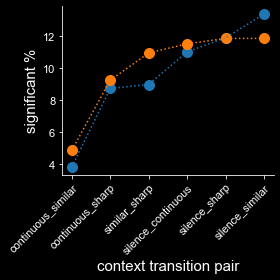

In [27]:
analysis = 'single cell'
value = 'significant %'

fig, ax = plt.subplots()

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.sort_values(by=['A1', 'PEG'], axis=0, ascending=[True, True])
trans_order = list(toplot.index)
_ = ax.plot(toplot.A1, color='C0', linestyle=':', label='A1')
_ = ax.scatter(range(6), toplot.A1, color='C0', s=100)
_ = ax.plot(toplot.PEG, color='C1', linestyle=':', label='PEG')
_ = ax.scatter(range(6), toplot.PEG, color='C1', s=100)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')
fig.set_size_inches(4,4)
title = 'triplets_single_cell_signif_percent_plot'
savefig(fig, 'DAC4', title)

### population

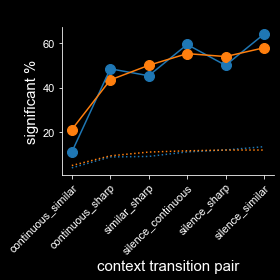

In [28]:
# for the population plots both single cell and population

fig, ax = plt.subplots()
#single cell
analysis = 'single cell'
value = 'significant %'
linestyle = ':'

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=trans_order)

_ = ax.plot(toplot.A1, color='C0', linestyle=linestyle, label=f'{analysis} A1')
_ = ax.plot(toplot.PEG, color='C1', linestyle=linestyle, label=f'{analysis} PEG')

# population
analysis = 'population'
value = 'significant %'
linestyle = '-'

toplot = grouped.loc[(analysis), (value)]
toplot = toplot.reset_index()
toplot = toplot.pivot(values=value, columns='region', index='trans_pair')
toplot = toplot.reindex(index=trans_order)

_ = ax.plot(toplot.A1, color='C0', label=f'{analysis} A1')
_ = ax.scatter(range(6), toplot.A1, color='C0', s=100)
_ = ax.plot(toplot.PEG, color='C1', label=f'{analysis} PEG')
_ = ax.scatter(range(6), toplot.PEG, color='C1', s=100)


# format ax labels

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('significant %')
ax.set_xlabel('context transition pair')

ax.set_title(' ')
fig.set_size_inches(4,4)


title = 'triplets_population_signif_percent_plot'
savefig(fig, 'DAC4', title)

In [29]:
trans_ord = trans_order
reg_ord = ['A1', 'PEG']
ana_ord = ['single cell', 'population']

In [30]:
# grid with proportion anotations
def anotated_nozero_scatter(x, y, **kws):
    total = x.shape[0]
    x = x[x>0]
    y = y[y>0]
    fontsize = kws.pop('fontsize', 12)
    n_signif = len(x)
    percent_good = n_signif / total * 100

    ax = plt.gca()
    ax.scatter(x, y, s=8, alpha=1, **kws)
    sns.kdeplot(x=x, y=y, ax=ax,**kws)
    ax.set_xlim(0,ax.get_xlim()[1])
    ax.set_ylim(0,ax.get_ylim()[1])

    ax.text(.5, 0.5, f'n {total}\n{percent_good:.2f}% signif', fontsize=fontsize, transform=ax.transAxes, **kws)


# plots showing the progression of the date split
## single cell

<ipython-input-31-a146c41140eb>:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


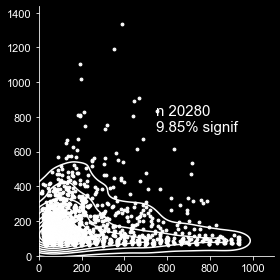

In [31]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]

g = sns.FacetGrid(data=scDF, row=None, col=None, hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="{row_name}", col_template="{col_name}")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(4, 4)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'single_cell_parameter_space_pooled'

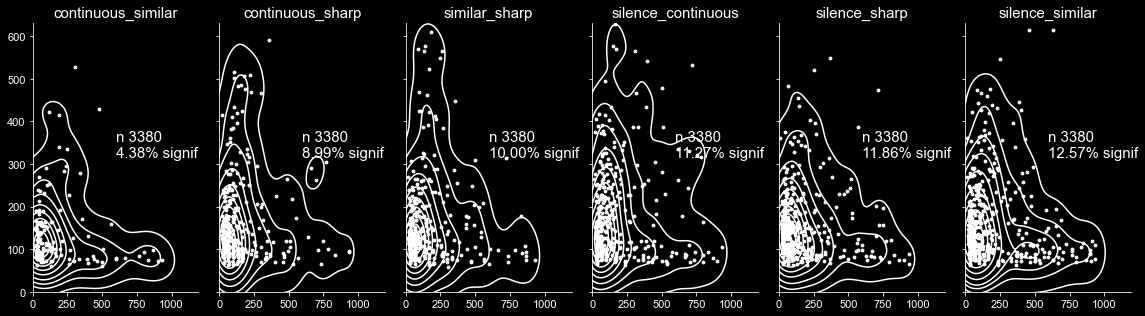

In [32]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row=None, col='trans_pair', hue=None,
                  sharex=True, sharey=True, legend_out=True,
                  row_order=ana_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", color='white', fontsize=15)
g.set_titles(template="")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
g.set_axis_labels("",
                  "")
fig = g.fig
fig.set_size_inches(16,4.5)
fig.tight_layout(rect=(0,0,1,1))

title = 'single_cell_parameter_space_transitions'

<ipython-input-33-c5e65d90cc57>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


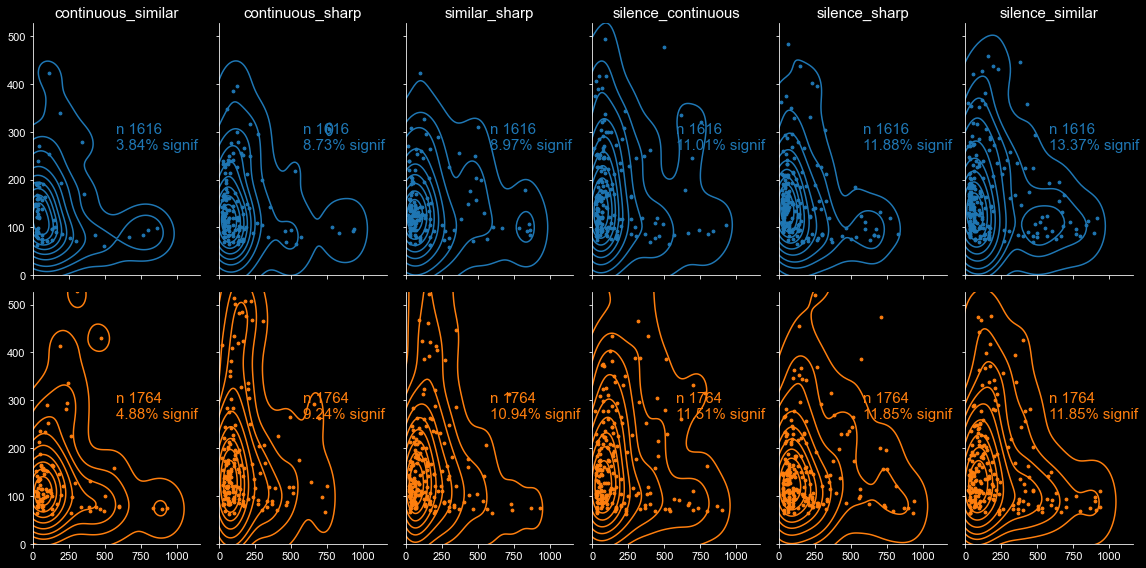

In [33]:
scDF = pivoted.loc[pivoted.analysis == 'single cell',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)', "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
# g.set_axis_labels("duration of contextual\ndiscrimination (ms)",
#                   "magnitude of contextual\ndiscrimination (d' * ms)")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'single_cell_parameter_space_trans_region'

## Population

<ipython-input-34-573d10276fbd>:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(rect=(0,0,0.98,0))


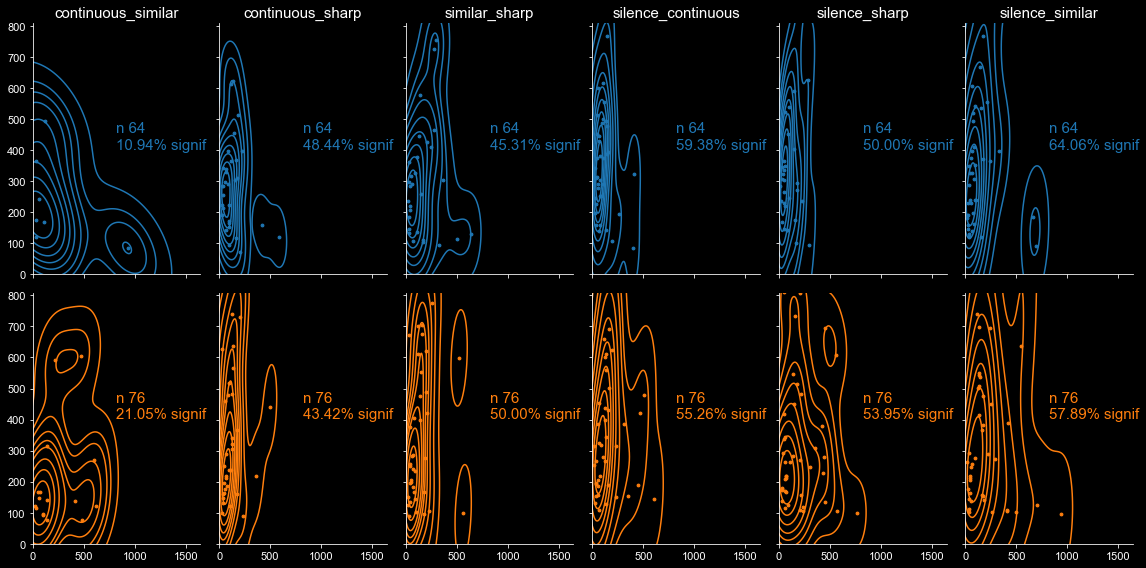

In [34]:
scDF = pivoted.loc[pivoted.analysis == 'population',:]
g = sns.FacetGrid(data=scDF, row='region', col='trans_pair', hue='region',
                  sharex=True, sharey=True, legend_out=True,
                  row_order=reg_ord, col_order=trans_ord, hue_order=reg_ord)
g.map(anotated_nozero_scatter, 'center of mass (ms)',  "integral (d'*ms)", fontsize=15)
g.set_titles(template="")
g.set_axis_labels("",
                  "")
g._margin_titles = True
g.set_titles(row_template="", col_template="{col_name}")
fig = g.fig
fig.set_size_inches(16,8)
fig.tight_layout(rect=(0,0,0.98,0))

title = 'population_parameter_space_trans_region'

# Anova tables

In [35]:
for ana, met in itt.product(['single cell', 'population'], ['center of mass (ms)', "integral (d'*ms)"]):
    ff_metric = filtered.metric == met
    ff_analysis = filtered.analysis == ana
    ff_val = filtered.value > 0
    anovaDF =  filtered.loc[ff_metric & ff_analysis & ff_val,
                         ['region', 'trans_pair', 'value']]

    modstr = 'value ~ C(region) + C(trans_pair) + C(region):C(trans_pair)'
    model = ols(modstr, data=anovaDF).fit()
    df = sm.stats.anova_lm(model, typ=2)

    title =f'\n {ana} {met}'
    print(title)
    print(df)

    # post hoc comparisons
    res = stat()
    for comp in ['region', 'trans_pair']:
        res.tukey_hsd(df=anovaDF, res_var= 'value', xfac_var=comp, anova_model=modstr)
        phocdf = res.tukey_summary
        phocdf = phocdf.loc[:, ['group1', 'group2', 'p-value']]
        print('\n', phocdf)



 single cell center of mass (ms)
                               sum_sq      df          F    PR(>F)
C(region)                5.398721e+05     1.0  15.049091  0.000108
C(trans_pair)            5.159953e+05     5.0   2.876704  0.013574
C(region):C(trans_pair)  1.312856e+05     5.0   0.731925  0.599474
Residual                 7.121002e+07  1985.0        NaN       NaN

   group1 group2  p-value
0    PEG     A1    0.001

                 group1              group2   p-value
0   silence_continuous     silence_similar  0.349702
1   silence_continuous       silence_sharp  0.900000
2   silence_continuous  continuous_similar  0.900000
3   silence_continuous    continuous_sharp  0.719627
4   silence_continuous       similar_sharp  0.900000
5      silence_similar       silence_sharp  0.378203
6      silence_similar  continuous_similar  0.372930
7      silence_similar    continuous_sharp  0.014084
8      silence_similar       similar_sharp  0.076848
9        silence_sharp  continuous_similar  0.9

# post hoc comparisons


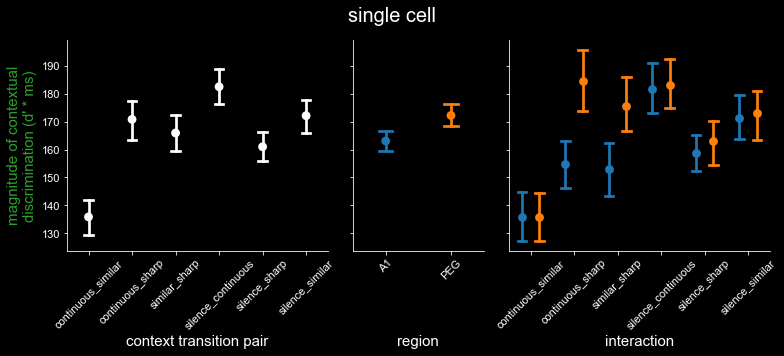

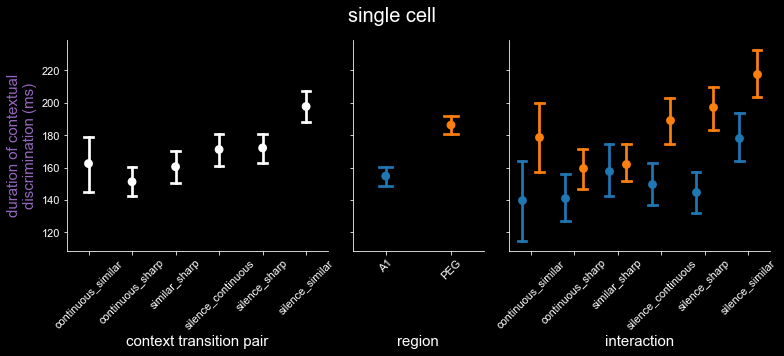

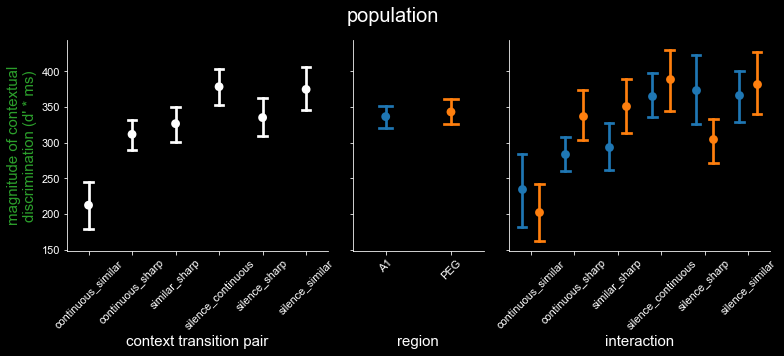

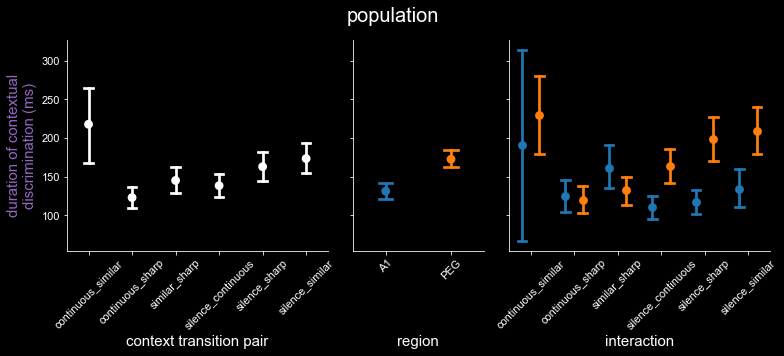

In [36]:
metric = "integral (d'*ms)"
# metric = "center of mass (ms)"
analysis = "single cell"
# analysis = "population"
metrics = ["integral (d'*ms)", "center of mass (ms)"]
analyses = ['single cell', 'population']
for analysis, metric in itt.product(analyses, metrics):
    tocalc = filtered.loc[(filtered.metric == metric) &
                          (filtered.analysis == analysis) &
                          (filtered.value >0),:]

    toplot = tocalc.loc[(tocalc.value < 600), :]

    if metric == "integral (d'*ms)":
        mname = 'integral'
        ylname = "magnitude of contextual\ndiscrimination (d' * ms)"
        lab_color = 'C2'
    elif metric == "center of mass (ms)":
        mname = 'center_of_mass'
        ylname = "duration of contextual\ndiscrimination (ms)"
        lab_color = 'C4'

    # plots the comparison by transition pair and by region in subplots of the same figures
    # gs_kw = dict(width_ratios=[1,0.5], height_ratios=[1])
    gs_kw = dict(width_ratios=[1, 0.5, 1], height_ratios=[1])
    # fig, (trans_ax, reg_ax) = plt.subplots(1, 2, sharey=True, gridspec_kw=gs_kw)
    fig, (trans_ax, reg_ax, int_ax) = plt.subplots(1, 3, sharey=True, gridspec_kw=gs_kw)
    fig.set_size_inches(11,5)

    #transitions
    _ = sns.pointplot(x='trans_pair', y='value', data=tocalc, order=trans_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=['white'], capsize=0.2, ci=68, ax=trans_ax)
    trans_ax.legend([],[], frameon=False)
    trans_ax.set_xticklabels(trans_ord, rotation = 45)

    trans_ax.set_xlabel('context transition pair')
    trans_ax.set_ylabel(ylname)
    trans_ax.yaxis.label.set_color(lab_color)

    # regions
    _ = sns.pointplot(x='region', y='value', data=tocalc, order=reg_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=sns.color_palette(), capsize=0.2, ci=68, ax=reg_ax)

    reg_ax.legend([],[], frameon=False)
    reg_ax.set_xticklabels(reg_ord, rotation = 45)
    reg_ax.set_xlabel('region')
    reg_ax.set_ylabel("")

    # interaction
    int_ax = sns.pointplot(x='trans_pair', y='value', hue='region', data=tocalc, order=trans_ord, hue_order=reg_ord,
                   s=2, dodge=0.4, join=False, capsize=0.2, ci=68, ax=int_ax)
    int_ax.legend([],[], frameon=False)
    int_ax.set_xticklabels(trans_ord, rotation = 45)
    int_ax.set_xlabel('interaction')
    int_ax.set_ylabel('')

    fig.align_labels()
    title =f'triplets {analysis}_post_hoc_{mname}'
    fig.suptitle(f'{analysis}', fontsize=20)
    savefig(fig, 'DAC4', title)

# single cell population comparison

In [37]:
# display(pivoted)
indexed = pivoted
indexed['siteid'] = pivoted['id'].apply(lambda x: x[:7] )
indexed = indexed.set_index(['analysis', 'id', 'region', 'siteid', 'context_pair', 'trans_pair', 'probe'])

indexed = indexed.droplevel(1)
merge = pd.merge(left=indexed.loc['single cell'], right=indexed.loc['population'],
                 left_index=True, right_index=True,
                 suffixes=(' single cell', ' population'))
# display(merge)

filtmerge = merge.loc[(merge["integral (d'*ms) single cell"]>0) &
                      (merge["integral (d'*ms) population"]>0), :]
display(filtmerge)

metric                                                      center of mass (ms) single cell  \
region siteid  context_pair       trans_pair         probe                                    
A1     AMT020a continuous_sharp   continuous_sharp   6                           132.985277   
                                                     6                           135.435925   
                                                     6                           130.829480   
               continuous_similar continuous_similar 2                           865.787064   
                                                     2                            27.798686   
...                                                                                     ...   
PEG    CRD014b silence_continuous silence_continuous 6                            59.268937   
                                                     6                            71.323436   
               silence_sharp      silence_sharp      3                            39.841046   
               similar_sharp      similar_sharp      3                           196.901600   
                                                     3                           336.153241   

metric                                                      integral (d'*ms) single cell  \
region siteid  context_pair       trans_pair         probe                                 
A1     AMT020a continuous_sharp   continuous_sharp   6                        116.158192   
                                                     6                         95.234089   
                                                     6                        277.641249   
               continuous_similar continuous_similar 2                         97.634959   
                                                     2                        166.815629   
...                                                                                  ...   
PEG    CRD014b silence_continuous silence_continuous 6                        111.180998   
                                                     6                        297.500041   
               silence_sharp      silence_sharp      3                        234.354438   
               similar_sharp      similar_sharp      3                        146.815282   
                                                     3                         82.000221   

metric                                                      mean d' single cell  \
region siteid  context_pair       trans_pair         probe                        
A1     AMT020a continuous_sharp   continuous_sharp   6                 1.161582   
                                                     6                 0.952341   
                                                     6                 1.041155   
               continuous_similar continuous_similar 2                 0.976350   
                                                     2                 1.668156   
...                                                                         ...   
PEG    CRD014b silence_continuous silence_continuous 6                 1.111810   
                                                     6                 1.487500   
               silence_sharp      silence_sharp      3                 1.757658   
               similar_sharp      similar_sharp      3                 0.880892   
                                                     3                 0.820002   

metric                                                      center of mass (ms) population  \
region siteid  context_pair       trans_pair         probe                                   
A1     AMT020a continuous_sharp   continuous_sharp   6                           84.886223   
                                                     6                           84.886223   
                                                     6                           84.886223   
               co

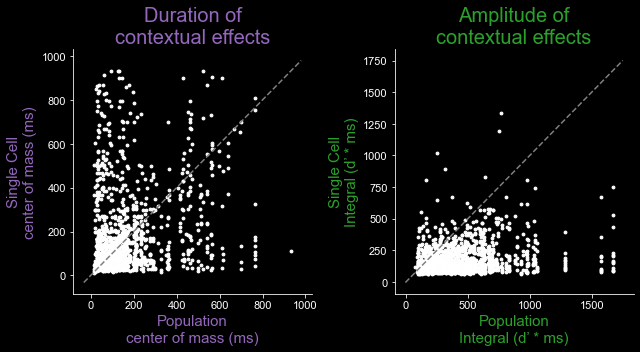

In [38]:
fig, (dur_ax, amp_ax) = plt.subplots(1,2)
fig.set_size_inches(9,5)

dur_ax.scatter(filtmerge.loc[:,"center of mass (ms) population"], filtmerge.loc[:,"center of mass (ms) single cell"],
               color='white', s=8)
dur_ax.set_xlabel("Population\ncenter of mass (ms)")
dur_ax.set_ylabel("Single Cell\ncenter of mass (ms)")
dur_ax.xaxis.label.set_color('C4')
dur_ax.yaxis.label.set_color('C4')
dur_ax.set_title('Duration of\ncontextual effects', color='C4')

amp_ax.scatter(filtmerge.loc[:,"integral (d'*ms) population"], filtmerge.loc[:,"integral (d'*ms) single cell"],
               color='white', s=8)
amp_ax.set_xlabel("Population\nIntegral (d’ * ms)")
amp_ax.set_ylabel("Single Cell\nIntegral (d’ * ms)")
amp_ax.xaxis.label.set_color('C2')
amp_ax.yaxis.label.set_color('C2')
amp_ax.set_title('Amplitude of\ncontextual effects', color='C2')

for ax in (dur_ax, amp_ax):
    _ = unit_line(ax, True)

title =f'SC_pop_metric_comparison'

# Example cell

In [39]:
best_cells = pivoted.loc[(pivoted.analysis == 'single cell') &
                         (pivoted['center of mass (ms)'] > 0),:]
# best_cells = best_cells.sort_values(by=["mean d'", 'center of mass (ms)'], ascending=[False, False])
best_cells = best_cells.sort_values(by=["integral (d'*ms)", 'center of mass (ms)'], ascending=[False, False])
display(best_cells.head(5))

metric,analysis,region,id,context_pair,trans_pair,probe,center of mass (ms),integral (d'*ms),mean d',siteid
1793,single cell,A1,AMT021b-05-2,silence_similar,silence_similar,3,388.333268,1337.712775,1.672141,AMT021b
1797,single cell,A1,AMT021b-05-2,similar_sharp,similar_sharp,3,349.453859,1191.327917,1.786992,AMT021b
15771,single cell,PEG,ARM021b-36-8,continuous_sharp,continuous_sharp,6,193.501707,1103.036516,2.206073,ARM021b
15790,single cell,PEG,ARM021b-36-8,similar_sharp,similar_sharp,5,195.573595,1016.494841,1.905928,ARM021b
3278,single cell,A1,ARM031a-40-2,silence_sharp,silence_sharp,5,470.146268,907.465983,1.088959,ARM031a
